## **1. Mount google drive**
---

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## **2. Import the libraries**
---

In [3]:
import sys
import os
import matplotlib
import librosa
import timeit
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import zipfile
import sklearn.metrics as metrics

from IPython.display import clear_output
from scipy.io import wavfile
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from tensorflow.keras.callbacks import ModelCheckpoint,CSVLogger
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model

print("Versions of key libraries")
print("---")
print("tensorflow:", tf.__version__)
print("numpy:     ", np.__version__)
print("matplotlib:", matplotlib.__version__)
print("pandas    :", pd.__version__)
print("librosa   :", librosa.__version__)
print("sklearn   :", sklearn.__version__)


Versions of key libraries
---
tensorflow: 2.6.0
numpy:      1.19.5
matplotlib: 3.2.2
pandas    : 1.1.5
librosa   : 0.8.1
sklearn   : 0.22.2.post1


## **3. Copy data.zip from google drive to local directory**
---

In [4]:
print("Copy speechsub.zip from google drive to local directory ...")
zipSrc  = zipfile.ZipFile("/content/gdrive/My Drive/iss/RTAVS/audio/data/speechsub.zip", 'r')

print("Unzip speechsub.zip ...")
zipSrc.extractall("/content")

zipSrc.close()
print("Unzip completes.")

Copy speechsub.zip from google drive to local directory ...
Unzip speechsub.zip ...
Unzip completes.


## **4. Change working directory to /content/**
---

In [5]:
os.chdir('/content/')
print("Current working directory:")
os.getcwd()

Current working directory:


'/content'

## **5. Setup matplotlib**
---

In [6]:
plt.style.use('seaborn')                   # if want to use the default style, set 'classic'
plt.rcParams['ytick.right']     = True
plt.rcParams['ytick.labelright']= True
plt.rcParams['ytick.left']      = False
plt.rcParams['ytick.labelleft'] = False
plt.rcParams['figure.figsize']  = [7,7]   # Set the figure size to be 7 inch for (width,height)

print("Matplotlib setup completes.")

Matplotlib setup completes.


## **6. Prepare the dataset (to be completed)**
---


In [7]:
# type your code below
audioPth    = 'speechsub'
allRecords  = []
allLabels   = []

labels      = ["go",
               "stop",
               "yes", 
               "no", 
               "up", 
               "down", 
               "left", 
               "right", 
               "on", 
               "off"]                                                                            # Step 2

totalRecords= 0
numOfRecords= []
for lbl in labels:
                                                                                # Step 3
    pth     = os.path.join(audioPth,lbl)
    records = [f for f in os.listdir(pth) if f.endswith('.wav')]
    
    numOfRecords.append(len(records))                                           # Step 4
    totalRecords    = totalRecords+len(records)



resmpRate   = 8000
inputLength = 8000
fftSize = 512

                                                                                # Step 3
start       = timeit.default_timer()
run         = 1

for lbl in labels:
                                                                                # Step 4
    pth     = os.path.join(audioPth,lbl)
    #print(pth)
    records = [f for f in os.listdir(pth) if f.endswith('.wav')]

    for rcd in records:
        #print(rcd)                                                                        # Step 5
        (smp,smpR)  = librosa.load(os.path.join(pth,rcd),sr=16000)
        smp         = librosa.resample(smp,
                                       smpR, 
                                       resmpRate) 
        smpMfcc = librosa.feature.mfcc(y=smp,sr=resmpRate,n_mfcc=32)
        smpMfcc = sklearn.preprocessing.scale(smpMfcc,axis=1)
                                                                              # Step 6
        if (len(smp)==inputLength): 
          allRecords.append(smpMfcc)
          allLabels.append(lbl)                                                                       # Step 7
        clear_output(wait=True)
        stop    = timeit.default_timer()

        if (run/totalRecords) < 0.05:
            timeExpected  = "Calculating ..."
        else:
            timeNow       = timeit.default_timer()
            timeExpected  = np.round((timeNow-start)/run*totalRecords/60,2)

        print("Checking progress:", run ,"records")   
        print("Time taken       : ", np.round((stop-start)/60,2), "minutes")
        print("Expected duration:", timeExpected, "minutes")
        print('')

        run     = run+1

Checking progress: 23682 records
Time taken       :  35.72 minutes
Expected duration: 35.72 minutes



In [8]:
allRecords = np.array(allRecords)  
allLabels = np.array(allLabels)
print("The shape of allRecords is", allRecords.shape, "and the data type is", allRecords.dtype)
print("The shape of allLabels is", allLabels.shape)

The shape of allRecords is (21312, 32, 32) and the data type is float32
The shape of allLabels is (21312,)


## **7. Prepare the labels**
---
* Step 1: Create label encoder
* Step 2: Generate the labels
* Step 3: Extract the mapping between numbers and labels
* Step 4: Convert each item in `classes` to string
* Step 5: Perform one-hot encoding

In [9]:
le      = LabelEncoder()                                                        # Step 1
lbls    = le.fit_transform(allLabels)                                           # Step 2
classes = list(le.classes_)                                                     # Step 3
classes = [str(c) for c in classes]                                             # Step 4
lbls    = to_categorical(lbls,num_classes=len(classes))                         # Step 5

print(classes)

['down', 'go', 'left', 'no', 'off', 'on', 'right', 'stop', 'up', 'yes']


## **8. Split the dataset into training and testing set**
---

In [10]:
(trDat,
 vlDat,
 trLbl, 
 vlLbl) = train_test_split(allRecords,
                           lbls,
                           stratify=lbls,
                           test_size=0.2,
                           random_state=229,
                           shuffle=True)
 
print("The shape of trDat is", trDat.shape)
print("The shape of vlDat is", vlDat.shape)

The shape of trDat is (17049, 32, 32)
The shape of vlDat is (4263, 32, 32)


## **9. Define deep learning model (to be completed)**
---
* Step 1: Set a name for the coming model (required for saving)
* Step 2: Define the convolutional neural network model (to be completed)
* Step 3: Create models for training and testing
* Step 4: Display the summary of the model of interest 

In [12]:
modelname    = 'speechRV2'                                                      # Step 1

                                                                                # Step 2
def createModel(row,col):
    ipt = Input(shape=(row,col,1))
    x = Conv2D(32,(3,3), padding='valid', activation='relu')(ipt)
    x = MaxPooling2D((2,2))(x)
    x = Dropout(0.25)(x)
 
    x = Conv2D(64,(3,3), padding='valid', activation='relu')(x)
    x = MaxPooling2D((2,2))(x)
    x = Dropout(0.25)(x)
    
    x = Conv2D(128,(3,3), padding='valid', activation='relu')(x)
    x = MaxPooling2D((2,2))(x)
    x = Dropout(0.25)(x)

    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.25)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.25)(x)
    x = Dense(len(classes), activation='softmax')(x)
    model = Model(ipt, x)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) 
    return model

nrow = trDat.shape[1]
ncol = trDat.shape[2]                                                                           # Step 3
model       = createModel(nrow,ncol) # This is meant for training
modelGo     = createModel(nrow,ncol) # This is used for final testing

model.summary()                                                                 # Step 4


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 1)]       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 6, 6, 64)          0     

## **10. Create callbacks**
---
* Step 1: Create a callback to save the model from an epoch when validation accuracy is the highest
* Step 2: Create a callback to save the training loss, training accuracy, validation loss and validation accuracy of each epoch into a csv file
* Step 3: Put the two callbacks objects into a list

In [13]:
                                                                                # Step 1
folderpath      = '/content/gdrive/My Drive/iss/rtavs/colab/'
filepath        = folderpath + modelname + ".hdf5"
checkpoint      = ModelCheckpoint(filepath, 
                                  monitor='val_accuracy', 
                                  verbose=0, 
                                  save_best_only=True, 
                                  mode='max')

csv_logger      = CSVLogger(folderpath+modelname +'.csv')                       # Step 2
callbacks_list  = [checkpoint,csv_logger]                                       # Step 3

print("Callbacks created:")
print(callbacks_list[0])
print(callbacks_list[1])
print('')
print("Path to model:", filepath)
print("Path to log:  ", folderpath+modelname+'.csv')

Callbacks created:

Path to model: /content/gdrive/My Drive/iss/rtavs/colab/speechRV2.hdf5
Path to log:   /content/gdrive/My Drive/iss/rtavs/colab/speechRV2.csv


## **11. Train the deep learning model**
---

In [14]:
model.fit(trDat, 
          trLbl, 
          validation_data=(vlDat, vlLbl), 
          epochs=250, 
          batch_size=32,
          shuffle=True,
          callbacks=callbacks_list)

Epoch 1/250
533/533 [==============================] - 28s 51ms/step - loss: 2.1040 - accuracy: 0.1952 - val_loss: 1.2992 - val_accuracy: 0.5311
Epoch 2/250
533/533 [==============================] - 27s 50ms/step - loss: 1.1514 - accuracy: 0.5765 - val_loss: 0.6821 - val_accuracy: 0.7640
Epoch 3/250
533/533 [==============================] - 27s 50ms/step - loss: 0.8584 - accuracy: 0.6985 - val_loss: 0.5954 - val_accuracy: 0.8008
Epoch 4/250
533/533 [==============================] - 27s 51ms/step - loss: 0.7357 - accuracy: 0.7453 - val_loss: 0.5260 - val_accuracy: 0.8191
Epoch 5/250
533/533 [==============================] - 27s 51ms/step - loss: 0.6606 - accuracy: 0.7773 - val_loss: 0.4535 - val_accuracy: 0.8485
Epoch 6/250
533/533 [==============================] - 27s 50ms/step - loss: 0.6313 - accuracy: 0.7858 - val_loss: 0.4362 - val_accuracy: 0.8515
Epoch 7/250
533/533 [==============================] - 26s 50ms/step - loss: 0.5881 - accuracy: 0.8022 - val_loss: 0.4077 - val_ac

## **12. Validate the deep learning model**
---
* Step 1: Load the trained weights and compile the model
* Step 2: Make prediction

In [15]:
                                                                                # Step 1
modelGo.load_weights(filepath)
modelGo.compile(loss='categorical_crossentropy', 
                optimizer='adam', 
                metrics=['accuracy'])

predicts    = modelGo.predict(vlDat)                                            # Step 2
print("Prediction completes.")

Prediction completes.


## **13. Report classification metrics**
---
* Step 1: Convert label from one-hot to integer
* Step 2: Calculate the accuracy score
* Step 3: Generate classification report

In [16]:
                                                                                # Step 1
predout     = np.argmax(predicts,axis=1)
testout     = np.argmax(vlLbl,axis=1)

testScores  = metrics.accuracy_score(testout,predout)                           # Step 2

                                                                                # Step 3
print("Best accuracy (on testing dataset): %.2f%%" % (testScores*100))
print(metrics.classification_report(testout,
                                    predout,
                                    target_names=classes,
                                    digits=4))

Best accuracy (on testing dataset): 92.38%
              precision    recall  f1-score   support

        down     0.9550    0.9372    0.9460       430
          go     0.8899    0.9048    0.8973       420
        left     0.9372    0.9307    0.9340       433
          no     0.9320    0.8810    0.9058       420
         off     0.8839    0.8695    0.8766       429
          on     0.9132    0.9501    0.9313       421
       right     0.9626    0.9559    0.9593       431
        stop     0.9310    0.9609    0.9457       435
          up     0.8687    0.8835    0.8761       412
         yes     0.9629    0.9606    0.9618       432

    accuracy                         0.9238      4263
   macro avg     0.9236    0.9234    0.9234      4263
weighted avg     0.9240    0.9238    0.9237      4263



## **14. Print confusion matrix**
---

In [17]:
confusion   = metrics.confusion_matrix(testout,predout)
print(confusion)

[[403   7   1   6   0   5   0   2   5   1]
 [  7 380   1  14   5   3   1   2   4   3]
 [  1   0 403   0   3   1   9   3   4   9]
 [  6  29   4 370   2   0   1   4   3   1]
 [  1   3   3   3 373  16   3   3  24   0]
 [  0   2   3   0  10 400   0   0   5   1]
 [  1   2   5   0   2   6 412   1   2   0]
 [  1   2   1   2   5   2   0 418   4   0]
 [  0   0   5   1  21   5   1  14 364   1]
 [  2   2   4   1   1   0   1   2   4 415]]


## **15. Plot curves on validation loss and accuracy**
---

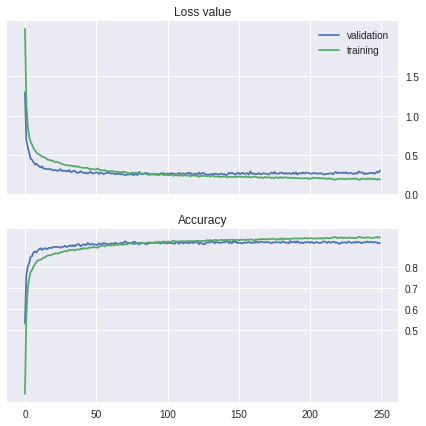

In [18]:
records     = pd.read_csv(folderpath+modelname +'.csv')
plt.figure()
plt.subplot(211)
plt.plot(records['val_loss'], label="validation")
plt.plot(records['loss'],label="training")
plt.yticks([0.00,0.50,1.00,1.50])
plt.title('Loss value',fontsize=12)

ax          = plt.gca()
ax.set_xticklabels([])

plt.subplot(212)
plt.plot(records['val_accuracy'],label="validation")
plt.plot(records['accuracy'],label="training")
plt.yticks([0.5,0.6,0.7,0.8])
plt.title('Accuracy',fontsize=12)
ax.legend()
plt.show()

## **16. Save the model plot**
---

In [19]:
plotpath  = folderpath+modelname+'_plot.png'
plot_model(model, 
           to_file=plotpath, 
           show_shapes=True, 
           show_layer_names=False,
           rankdir='TB')

print("Path to plot:", plotpath)

Path to plot: /content/gdrive/My Drive/iss/rtavs/colab/speechRV2_plot.png


## **17. Create a function to make prediction on a wavefile**
---

In [20]:
def commandPred(file):
    (smp,smpR)  = librosa.load(file,sr=16000)
    smpMfcc     = librosa.feature.mfcc(y=smp,
                                       sr=16000,
                                       n_mfcc=32)
    smpMfcc     = sklearn.preprocessing.scale(smpMfcc,axis=1)
                                                 # The output size is (32,32)                                       

    smpMfcc     = np.expand_dims(smpMfcc,axis=0) # The output size is (1,32,32)
    smpMfcc     = np.expand_dims(smpMfcc,axis=3) # The output size is (1,32,32,1)
    pred        = modelGo.predict(smpMfcc)
    pred        = np.argmax(pred,axis=1)
    
    return classes[pred[0]]


# ............................................................................
    
wfile       = '/content/gdrive/My Drive/iss/RTAVS/audio/data/voice01.wav'
pred        = commandPred(wfile)
print("The command predicted from '%s' is '%s'." % (wfile,pred) )

The command predicted from '/content/gdrive/My Drive/iss/RTAVS/audio/data/voice01.wav' is 'right'.


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:173: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
